In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#file = "../data/cleaned/amazon_sales_clean.csv"
#df = pd.read_csv(file)
#df.head()

In [ ]:
from sqlalchemy import create_engine

engine = create_engine(
    "mysql+pymysql://<username>:<password>@localhost:3306/amazon_sales_analysis"
)

In [16]:
query = "SELECT * FROM amazon_sales"
df = pd.read_sql(query, engine)

In [17]:
df.shape

(128713, 21)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128713 entries, 0 to 128712
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   order_id            128713 non-null  object        
 1   date                128713 non-null  datetime64[ns]
 2   status              128713 non-null  object        
 3   fulfilment          128713 non-null  object        
 4   sales_channel       128713 non-null  object        
 5   ship_service_level  128713 non-null  object        
 6   style               128713 non-null  object        
 7   sku                 128713 non-null  object        
 8   category            128713 non-null  object        
 9   size                128713 non-null  object        
 10  asin                128713 non-null  object        
 11  courier_status      128713 non-null  object        
 12  qty                 128713 non-null  int64         
 13  currency            128713 no

In [19]:
df['date'].min(),df['date'].max()

(Timestamp('2022-03-31 00:00:00'), Timestamp('2022-06-29 00:00:00'))

In [20]:
df[['amount','qty']].describe()

,amount,qty
count,128713.000000,128713.000000
mean,556.717294,0.904765
std,346.762477,0.307147
min,0.000000,0.000000
25%,376.000000,1.000000
50%,545.000000,1.000000
75%,761.000000,1.000000
max,5584.000000,8.000000


Data Validation:

- Dataset has 1,28,713 rows and 21 columns after SQL import.
- No missing values; key fields have correct data types.
- Data ranges from 31-Mar-2022 to 29-Jun-2022, suitable for trend analysis.
- Transaction values and quantities fall within realistic business ranges.


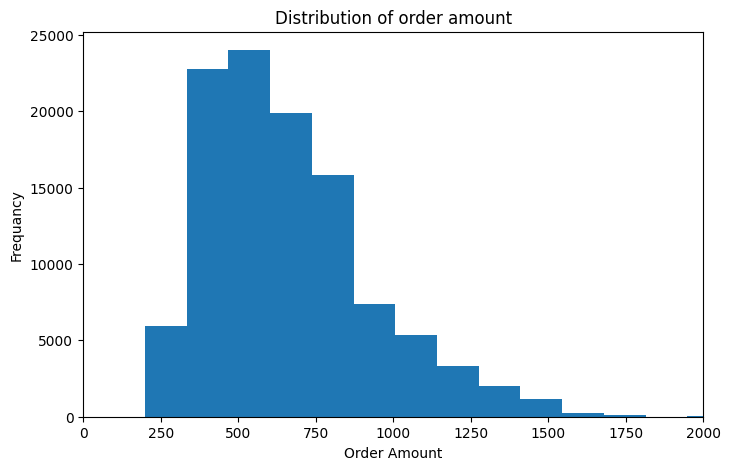

In [21]:
data = df[df['amount']>0]['amount']

plt.figure(figsize=(8,5))
plt.hist(data,bins=40)
plt.xlim(0,2000)
plt.xlabel("Order Amount")
plt.ylabel('Frequancy')
plt.title("Distribution of order amount")
plt.show()

- Insight: Most orders fall between 300-900 rs with only a small number of high-value purchases.

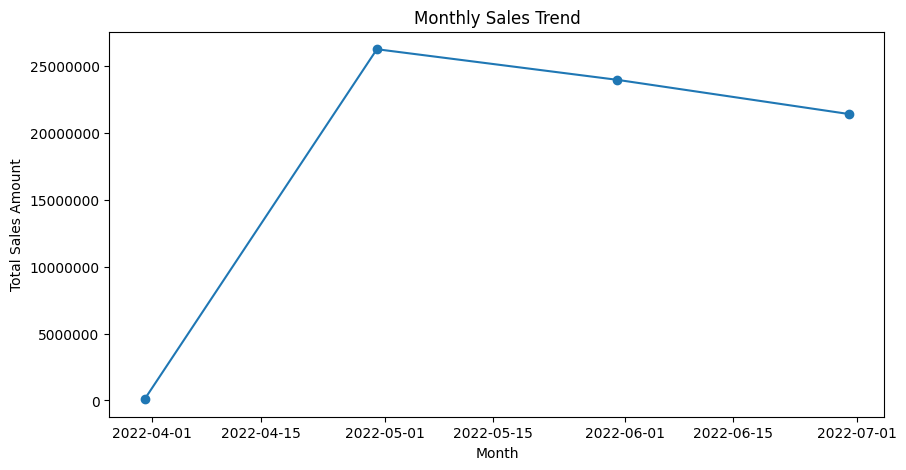

In [22]:
df['date'] = pd.to_datetime(df['date'],errors='coerce')
df['amount'] = pd.to_numeric(df['amount'],errors='coerce')


monthly_sales = ( df[df['amount']>0]
                 .groupby(pd.Grouper(key='date',freq='ME'))
                 ['amount'].sum().reset_index()
                 )
plt.figure(figsize=(10,5))
plt.plot(monthly_sales['date'],monthly_sales['amount'],marker = 'o')
plt.xlabel('Month')
plt.ylabel('Total Sales Amount')
plt.title('Monthly Sales Trend')
plt.ticklabel_format(style='plain',axis='y')
plt.show()

- Insight: Sales rise till May and then drop, which may point to seasonal demand or short-term  campaigns.

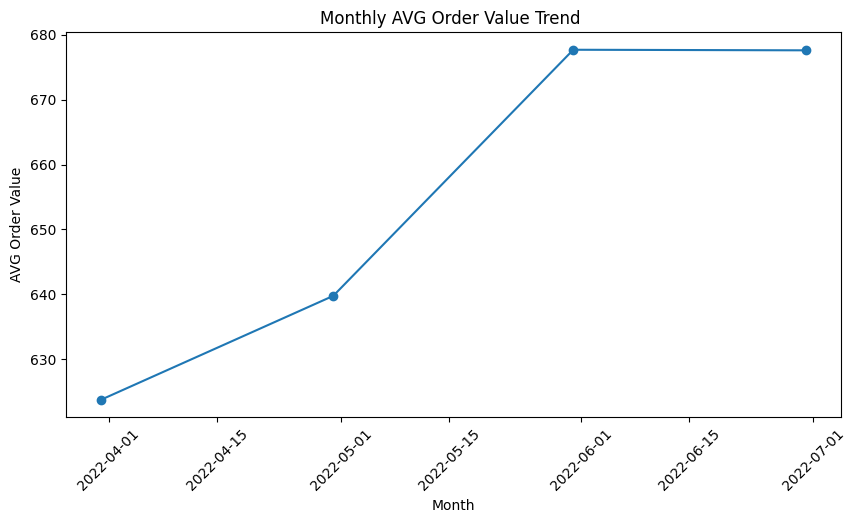

In [23]:
monthly_aov = ( df[df['amount']>0]
                 .groupby(pd.Grouper(key='date',freq='ME'))
                 ['amount']
                 .mean()
                 .reset_index()
                 )
plt.figure(figsize=(10,5))
plt.plot(monthly_aov['date'],monthly_aov['amount'],marker = 'o')
plt.xlabel('Month')
plt.ylabel('AVG Order Value')
plt.title('Monthly AVG Order Value Trend ')
plt.xticks(rotation = 45)
plt.show()

- Insight: Even when sales fluctuate, the average bill value keeps improving, showing better product mix or pricing.

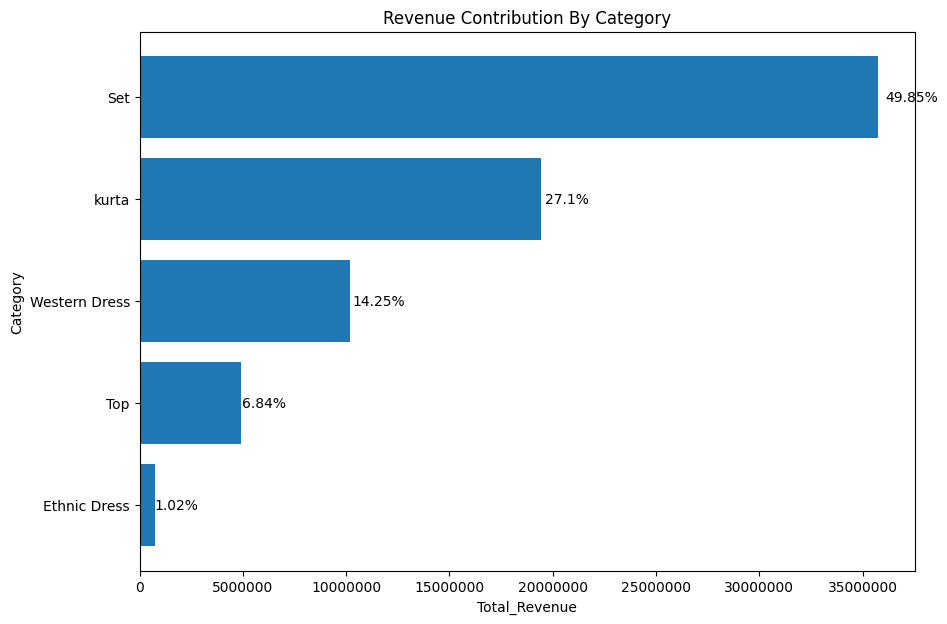

In [24]:
category_revenue = (df[df['amount']>0]
                    .groupby('category')['amount']
                    .sum()
                    .sort_values(ascending=False) 
                    )
top5 =category_revenue.head(5)

top5_pct = (top5/category_revenue.sum()*100).round(2)

plt.figure(figsize=(10,7))
plt.barh(top5.index[::-1],top5.values[::-1])
plt.xlabel("Total_Revenue")
plt.ylabel("Category")
plt.title("Revenue Contribution By Category")
plt.ticklabel_format(style='plain',axis='x')

for i ,(value,pct) in enumerate(zip(top5.values[::-1],
                                    top5_pct.values[::-1])):
    plt.text(value*1.01,i,f"{pct}%",va='center')
plt.show()

- Insight: Most of the revenue comes from sets, so sales are heavily dependant on one category.

Summary:

- Sales are mainly driven by the sets category, so overall revenue depends heavily on one product type
- Total sales increased till May and then started declining, suggesting short-term seasonality or campaign impact.
- Most customers place mid-range orders, with very few high-value purchases.
- Even when sales dropped, the average order value improved, indicating better pricing or product mix.

Business Recommendations:

- Increase visibility of other categories through bundles or combo offers to reduce dependence on sets.
- Plan promotional camapaigns in low-sales months to stabilize order volume.
- Introduce or highlight premium product options to continue improving average order value.
- Track category wise performance regularly to identify early signs of demand shift